In [59]:
import copy
import os
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

In [60]:
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 20

In [62]:
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode
        self.default_transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        if self.mode == 'single':
            self.data = self.load_data()
            self.sp = len(self.data)
            self.data.extend(self.data)
            
        else:
            self.data = self.load_data_dual()
            self.sp = len(self.data)
            self.data.extend(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        r = random.random()
        if self.transform and index >= self.sp:
            img = self.transform(img)
        else: 
            img = self.default_transform(img)
            

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform and index >= self.sp:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        else: 
            img1 = self.default_transform(img1)
            img2 = self.default_transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]

In [63]:
class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))

In [64]:
class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img


In [65]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.RandomInvert(p=0.1),
    transforms.RandomGrayscale(),
    transforms.RandomPerspective(p=0.1),    
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [66]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score
    kappas = np.zeros(num_epochs)

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')
        kappas[epoch - 1] = val_kappa

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model, kappas

In [67]:
def evaluate_model(model, test_loader, device, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics

In [68]:
def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

In [69]:
mode = 'single'
resnet18 = ("ResNET", models.resnet18(weights=models.ResNet18_Weights.DEFAULT))
vgg16 = ("VGG", models.vgg16(weights=models.VGG16_Weights.DEFAULT))
densenet161 = ("DenseNET", models.densenet161(weights=models.DenseNet161_Weights.DEFAULT))
name, model = resnet18

# Create datasets
train_dataset = RetinopathyDataset('./DeepDRiD/train.csv', './DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('./DeepDRiD/test.csv', './DeepDRiD/test/', transform_test, mode, test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train and evaluate the model with the training and validation set
model, kappas = train_model(
    model, train_loader, val_loader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_1_{}.pth'.format(name)
)

# Load the pretrained checkpoint
state_dict = torch.load('./model_1_{}.pth'.format(name), map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True, prediction_path="./test_predictions_{}.csv".format(name))

Device: cuda

Epoch 1/20
Training: 100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.36 batch/s, lr=1.0e-04, Loss=0.8442]
[Train] Kappa: 0.0016 Accuracy: 0.4796 Precision: 0.5433 Recall: 0.4796 Loss: 2.7667
[Train] Class 0: Precision: 0.7533, Recall: 0.7972
[Train] Class 1: Precision: 0.5518, Recall: 0.3438
[Train] Class 2: Precision: 0.3596, Recall: 0.2854
[Train] Class 3: Precision: 0.4645, Recall: 0.4229
[Train] Class 4: Precision: 0.4211, Recall: 0.3000
[Train] Class 5: Precision: 0.0000, Recall: 0.0000
[Train] Class 6: Precision: 0.0000, Recall: 0.0000
[Train] Class 7: Precision: 0.0000, Recall: 0.0000
[Train] Class 8: Precision: 0.0000, Recall: 0.0000
[Train] Class 9: Precision: 0.0000, Recall: 0.0000
[Train] Class 10: Precision: 0.0000, Recall: 0.0000
[Train] Class 11: Precision: 0.0000, Recall: 0.0000
[Train] Class 12: Precision: 0.0000, Recall: 0.0000
[Train] Class 13: Precision: 0.0000, Recall: 0.0000
[Train] Class 14: Precision: 0.0000, Recall: 0.0000


C:\Users\a4lu9\AppData\Local\Temp\ipykernel_19824\2074487963.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_1_{}.pth'.format(name), ma

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.61 batch/s]
[Test] Save predictions to C:\Users\a4lu9\koulu\DeepLearning\project\521153S-3005-final-project\test_predictions_ResNET-DUAL.csv


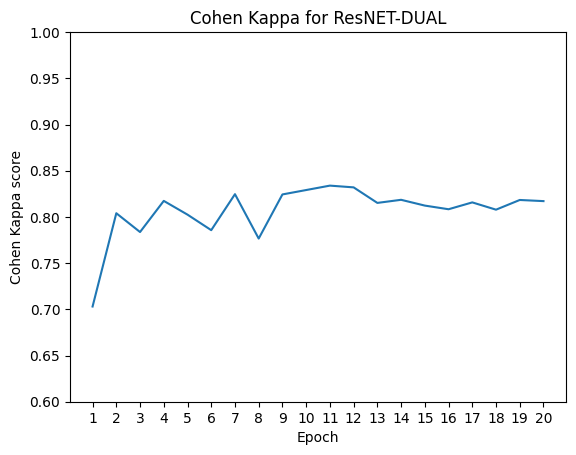

In [70]:
x = np.arange(1, num_epochs + 1, dtype=int)
x = list(map(str, x))
plt.plot(x, kappas)
plt.ylim(0.6, 1.0)
plt.xlabel("Epoch")
plt.ylabel("Cohen Kappa score")
plt.title("Cohen Kappa for {}".format(name))
plt.show()

In [73]:
state_dict = torch.load('./model_1_ResNET-0.8645.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True, prediction_path="./model_1_ResNET-0.8645.csv")

C:\Users\a4lu9\AppData\Local\Temp\ipykernel_19824\2798548734.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_1_ResNET-0.8645.pth', map_l

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.38 batch/s]
[Test] Save predictions to C:\Users\a4lu9\koulu\DeepLearning\project\521153S-3005-final-project\model_1_ResNET-0.8645.csv
